# ⚡ Elektrik Tüketimi Tahmini: Uçtan Uca Makine Öğrenmesi Projesi

**Amaç:** EPİAŞ (Tüketim) ve Hava Durumu verilerini kullanarak, Türkiye geneli saatlik elektrik tüketimini tahmin eden bir yapay zeka modeli geliştirmek.

**Süreç Adımları:**
1.  **Veri Yükleme:** Farklı kaynaklardan gelen verilerin birleştirilmesi.
2.  **Veri Temizliği:** Eksik, hatalı veya mükerrer verilerin kontrolü.
3.  **Özellik Mühendisliği (Feature Engineering):** Ham veriden modele zeka katacak yeni sütunların (Lag, Ağırlıklı Sıcaklık vb.) üretilmesi.
4.  **Keşifçi Veri Analizi (EDA):** Verinin görselleştirilmesi ve ilişkilerin anlaşılması.
5.  **Modelleme:** XGBoost algoritması ile eğitimin yapılması.
6.  **Değerlendirme:** Modelin başarısının ölçülmesi ve kaydedilmesi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib 

# Grafik ayarları (Rapor kalitesinde görseller için)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Kütüphaneler yüklendi.")

✅ Kütüphaneler yüklendi.


## 1. Veri Yükleme ve Birleştirme

Ham verilerimizi (`EPIAS` ve `Hava Durumu`) okuyup, **DateTime** (Tarih-Saat) sütunu üzerinden tek bir tablo haline getiriyoruz.

In [2]:
try:
    # 1. Dosyaları Oku
    df_epias = pd.read_csv("EPIAS_Gercek_Tuketim_Verileri.csv")
    df_weather = pd.read_csv("Hava_Durumu_Verileri.csv")
    
    # 2. Tarih Formatını Garantiye Al (String -> Datetime)
    df_epias["DateTime"] = pd.to_datetime(df_epias["DateTime"])
    df_weather["DateTime"] = pd.to_datetime(df_weather["DateTime"])

    # 3. Birleştirme (Merge)
    # Inner Join: Sadece her iki dosyada da karşılığı olan saatleri alır.
    df = pd.merge(df_epias, df_weather, on="DateTime", how="inner")
    
    print(f"✅ Veriler birleştirildi.")
    print(f"Toplam Satır Sayısı: {len(df)}")
    display(df.head()) 

except FileNotFoundError:
    print("❌ HATA: CSV dosyaları bulunamadı! Botları çalıştırdığınızdan emin olun.")

✅ Veriler birleştirildi.
Toplam Satır Sayısı: 12006


,DateTime,Tuketim_MWh,Ankara_Sicaklik,Erzurum_Sicaklik,Istanbul_Sicaklik,Izmir_Sicaklik
0,2024-07-26 00:00:00,44202.92,20.0,15.6,23.9,26.7
1,2024-07-26 01:00:00,42256.87,20.0,15.0,22.8,26.1
2,2024-07-26 02:00:00,39414.31,19.4,13.9,22.8,26.1
3,2024-07-26 03:00:00,39667.02,18.3,12.2,22.2,25.6
4,2024-07-26 04:00:00,38970.94,18.3,13.3,22.2,25.0


## 2. Veri Temizliği ve Kontrol (Data Cleaning)

Emlak projesinde olduğu gibi, modelin kafasını karıştıracak eksik (`NaN`) veya mükerrer (duplicate) verileri kontrol edip temizliyoruz.

In [3]:
# 1. Eksik Veri Kontrolü
print("--- Eksik Veri Sayıları ---")
print(df.isnull().sum())

# 2. Mükerrer (Tekrar Eden) Kayıt Kontrolü
duplicates = df.duplicated(subset=['DateTime']).sum()
print(f"\n--- Tekrar Eden Satır Sayısı: {duplicates} ---")

if duplicates > 0:
    print("⚠️ Tekrar eden kayıtlar siliniyor...")
    df = df.drop_duplicates(subset=['DateTime'], keep='last')

# 3. Mantıksız Veri Kontrolü (Örn: 0 veya Negatif Tüketim)
# Elektrik tüketimi 0 olamaz, böyle bir veri varsa hatalıdır.
hatali_veri = df[df['Tuketim_MWh'] <= 0]
if len(hatali_veri) > 0:
    print(f"⚠️ {len(hatali_veri)} adet hatalı (0 veya negatif) tüketim verisi bulundu ve siliniyor.")
    df = df[df['Tuketim_MWh'] > 0]
else:
    print("✅ Tüketim verileri mantıklı görünüyor (Hepsi > 0).")

print(f"\nTemizlik sonrası güncel satır sayısı: {len(df)}")

--- Eksik Veri Sayıları ---
DateTime             0
Tuketim_MWh          0
Ankara_Sicaklik      0
Erzurum_Sicaklik     0
Istanbul_Sicaklik    0
Izmir_Sicaklik       0
dtype: int64

--- Tekrar Eden Satır Sayısı: 0 ---
✅ Tüketim verileri mantıklı görünüyor (Hepsi > 0).

Temizlik sonrası güncel satır sayısı: 12006


## 3. Özellik Mühendisliği (Feature Engineering)

Veriye "Zeka" kattığımız yer burasıdır.
* **Ağırlıklı Sıcaklık:** İstanbul'un elektriğe etkisi ile Erzurum'un etkisi aynı değildir. Nüfus yoğunluğuna göre ağırlıklandırılmış bir sıcaklık endeksi oluşturuyoruz.
* **Zaman Bileşenleri:** Modelin "Saat 18:00'de tüketim artar" veya "Yazın klima açılır" gibi kalıpları öğrenmesi için tarihi parçalıyoruz.
* **Lag (Gecikme):** **En Kritik Özellik.** Modelin bugünü tahmin edebilmesi için ona "Dün bu saatte ne oldu?" bilgisini veriyoruz.

In [4]:
# A. Ağırlıklı Sıcaklık (Türkiye Geneli Tahmini İçin)
weights = {'Istanbul': 0.40, 'Ankara': 0.25, 'Izmir': 0.20, 'Erzurum': 0.15}

df['Weighted_Avg_Temp'] = (
    df['Istanbul_Sicaklik'] * weights['Istanbul'] +
    df['Ankara_Sicaklik'] * weights['Ankara'] +
    df['Izmir_Sicaklik'] * weights['Izmir'] +
    df['Erzurum_Sicaklik'] * weights['Erzurum']
).round(2)

# B. Tarihsel Parçalar (Zamanı Modele Öğretme)
df['Saat'] = df['DateTime'].dt.hour
df['Ay'] = df['DateTime'].dt.month
df['Yil'] = df['DateTime'].dt.year
df['Haftanin_Gunu'] = df['DateTime'].dt.dayofweek # 0=Pzt, 6=Paz

# C. Kategorik İşaretleyiciler (0 ve 1)
# Hafta Sonu mu? (Cmt-Paz ise 1, değilse 0)
df['Hafta_Sonu'] = df['Haftanin_Gunu'].apply(lambda x: 1 if x >= 5 else 0)

# Mesai Saati mi? (08:00 - 18:00 arası ise 1, değilse 0)
df['Mesai_Saati'] = df['Saat'].apply(lambda x: 1 if 8 <= x <= 18 else 0)

# D. LAG (Gecikme) Özelliği
# Bir önceki günün (24 saat öncesinin) tüketimini yan sütuna ekliyoruz.
df['Lag_Tuketim_24h'] = df['Tuketim_MWh'].shift(24)

# Shift işlemi ilk 24 satırı boş (NaN) bırakır. Boş verilerle model eğitilemez.
# O yüzden boş olan ilk günü siliyoruz.
df.dropna(inplace=True)

print("✅ Özellikler üretildi. Veri setinin son hali:")
display(df.tail())

✅ Özellikler üretildi. Veri setinin son hali:


,DateTime,Tuketim_MWh,Ankara_Sicaklik,Erzurum_Sicaklik,Istanbul_Sicaklik,Izmir_Sicaklik,Weighted_Avg_Temp,Saat,Ay,Yil,Haftanin_Gunu,Hafta_Sonu,Mesai_Saati,Lag_Tuketim_24h
12001,2025-12-08 10:00:00,46605.11,6.1,5.6,8.9,13.3,8.59,10,12,2025,0,0,1,30134.89
12002,2025-12-08 11:00:00,47056.20,6.7,6.1,8.9,13.9,8.93,11,12,2025,0,0,1,30428.57
12003,2025-12-08 12:00:00,45549.03,8.3,6.7,8.9,15.0,9.64,12,12,2025,0,0,1,30656.77
12004,2025-12-08 13:00:00,45926.37,8.3,7.2,8.9,15.0,9.72,13,12,2025,0,0,1,30803.29
12005,2025-12-08 14:00:00,46934.01,8.9,7.2,8.9,16.1,10.09,14,12,2025,0,0,1,32504.98


## 4. Keşifçi Veri Analizi (EDA)

Veriyi görselleştirerek anlamaya çalışıyoruz.
1.  **Korelasyon Matrisi:** Hangi özellik tüketimi en çok etkiliyor? (Lag ve Sıcaklık öne çıkmalı).
2.  **Hafta Sonu Etkisi:** Sanayi durduğu için hafta sonu tüketim düşüyor mu? (Boxplot ile göreceğiz).
3.  **Saatlik Dağılım:** Günün hangi saatlerinde zirve (peak) yaşanıyor?

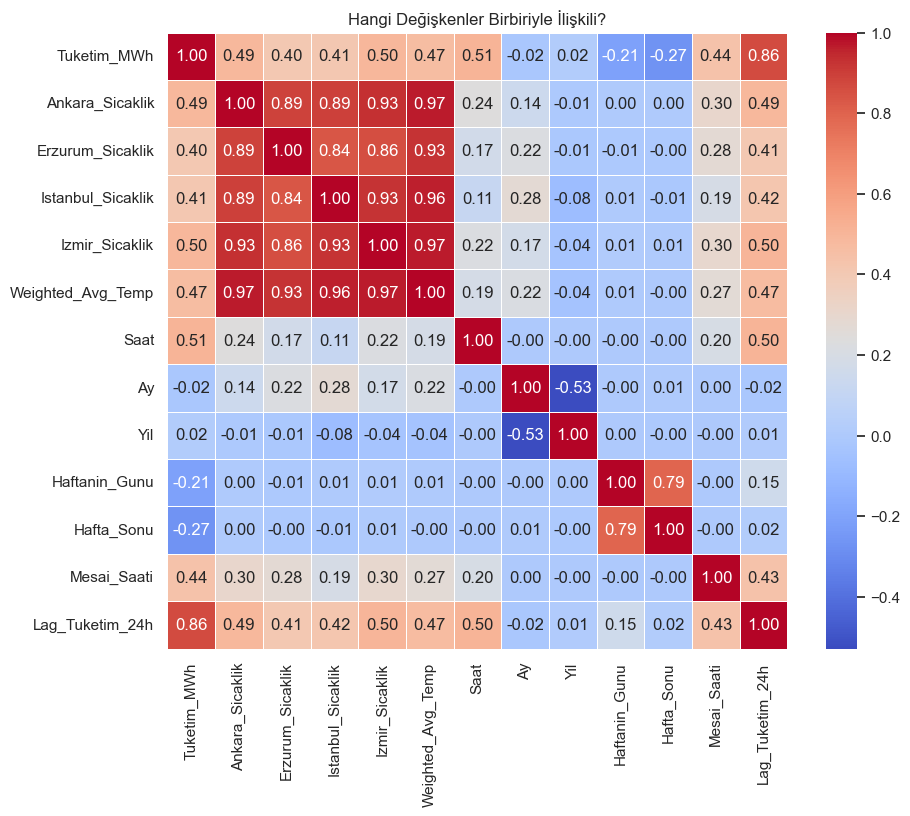

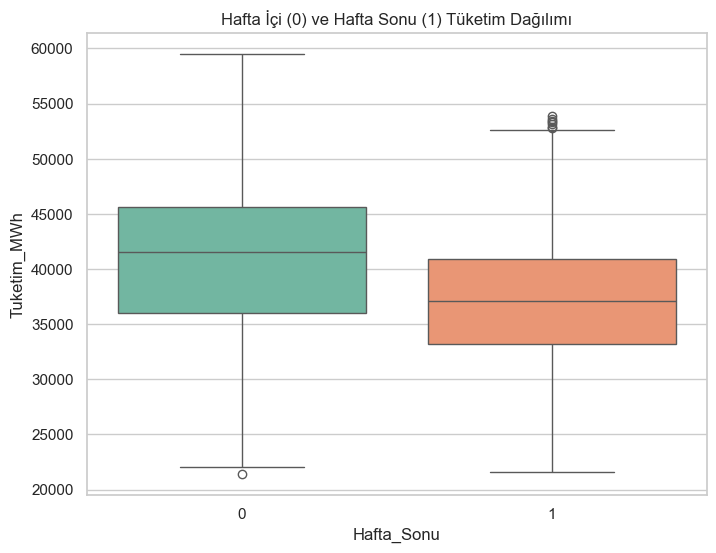

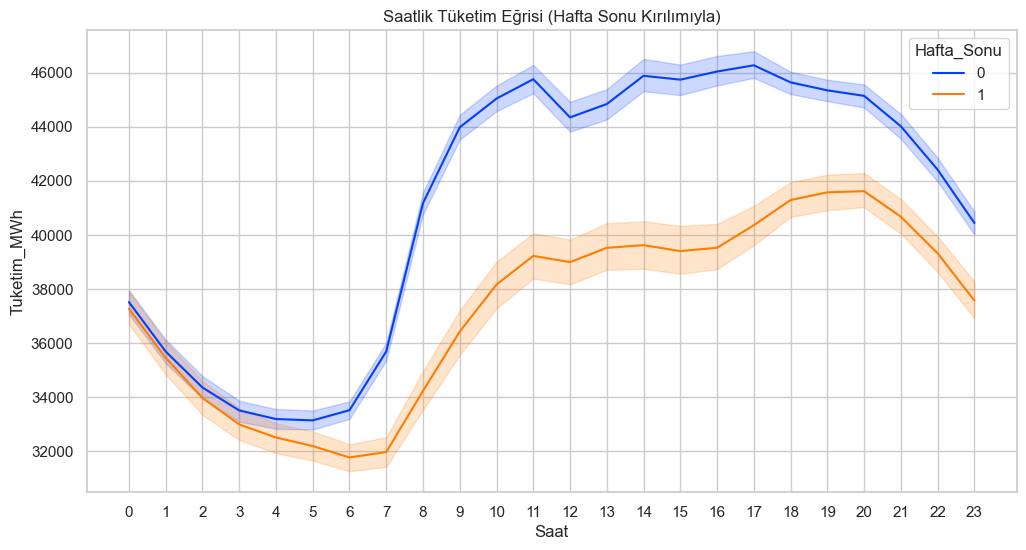

In [5]:
# 1. Korelasyon Matrisi (Isı Haritası)
plt.figure(figsize=(10, 8))
# Sadece sayısal sütunları seç
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Hangi Değişkenler Birbiriyle İlişkili?")
plt.show()

# 2. Hafta İçi vs Hafta Sonu Tüketimi (Boxplot) - DÜZELTİLDİ
plt.figure(figsize=(8, 6))
sns.boxplot(x='Hafta_Sonu', y='Tuketim_MWh', hue='Hafta_Sonu', data=df, palette='Set2', legend=False)
plt.title("Hafta İçi (0) ve Hafta Sonu (1) Tüketim Dağılımı")
plt.show()

# 3. Günün Saatlerine Göre Tüketim (Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Saat', y='Tuketim_MWh', data=df, hue='Hafta_Sonu', palette='bright')
plt.title("Saatlik Tüketim Eğrisi (Hafta Sonu Kırılımıyla)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## 4. Çoklu Model Eğitimi ve Karşılaştırma (Benchmark)

Bu aşamada, problemin çözümü için tek bir algoritma ile yetinmeyip, literatürdeki popüler regresyon algoritmalarını yarıştırıyoruz. Hedefimiz, hata payı en düşük olan modeli seçmektir.

**Kullanılan Algoritmalar:**
1.  **Linear Regression:** Temel referans (Baseline) modelimiz.
2.  **Ridge Regression:** Aşırı öğrenmeyi (Overfitting) engellemek için cezalandırma uygulayan lineer model.
3.  **Lasso Regression:** Gereksiz özellikleri elemeye çalışan lineer model.
4.  **Decision Tree (Karar Ağacı):** Veriyi dallara ayırarak tahmin yapan temel ağaç yapısı.
5.  **Random Forest:** Yüzlerce karar ağacının ortak kararıyla tahmin yapan güçlü bir model.
6.  **XGBoost:** Hata odaklı öğrenen (Gradient Boosting) ve yüksek performansıyla bilinen modern bir algoritma.

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1. Veri Hazırlığı
features = ['Weighted_Avg_Temp', 'Saat', 'Ay', 'Haftanin_Gunu', 'Hafta_Sonu', 'Mesai_Saati', 'Lag_Tuketim_24h']
target = 'Tuketim_MWh'

X = df[features]
y = df[target]

# Zaman serisi olduğu için shuffle=False (Geçmişle eğit, geleceği test et)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 2. Modellerin Tanımlanması
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, n_jobs=-1)
}

# 3. Eğitim ve Detaylı Değerlendirme Döngüsü
results = []
print(f"{'MODEL ADI':<20} | {'MAE':<10} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 60)

best_model = None
best_r2 = -np.inf 
best_model_name = ""

for name, model in models.items():
    # Eğit
    model.fit(X_train, y_train)
    
    # Test et
    predictions = model.predict(X_test)
    
    # Metrikleri Hesapla
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions)) # Karesel Hata (Büyük hataları cezalandırır)
    r2 = r2_score(y_test, predictions)
    
    # Listeye ekle
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    
    # Ekrana yazdır
    print(f"{name:<20} | {mae:.2f}       | {rmse:.2f}       | %{r2*100:.2f}")
    
    # En iyiyi seç (R2 skoruna göre)
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name

print("-" * 60)
print(f"🏆 EN İYİ MODEL: {best_model_name} (R2: %{best_r2*100:.2f})")

MODEL ADI            | MAE        | RMSE       | R2 Score  
------------------------------------------------------------
Linear Regression    | 1535.39       | 2111.40       | %85.22
Ridge Regression     | 1535.38       | 2111.42       | %85.22
Lasso Regression     | 1535.33       | 2111.64       | %85.21
Decision Tree        | 741.09       | 1069.45       | %96.21
Random Forest        | 638.08       | 936.99       | %97.09
XGBoost              | 636.79       | 894.75       | %97.35
------------------------------------------------------------
🏆 EN İYİ MODEL: XGBoost (R2: %97.35)


## 5. Model Karşılaştırma Grafiği

Elde ettiğimiz sonuçları görselleştirerek hangi modelin neden seçildiğini daha net gösteriyoruz.

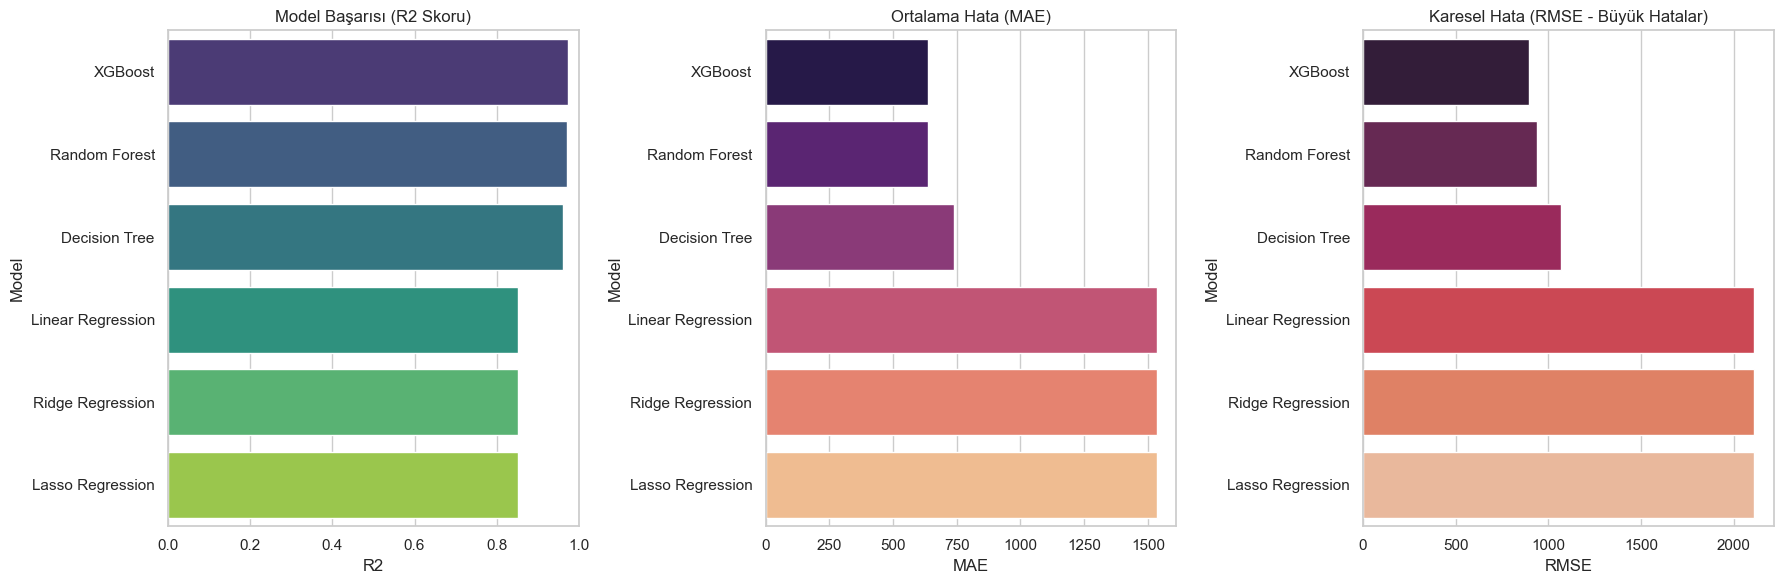

Seçilen Model: XGBoost
     Model        MAE        RMSE       R2
5  XGBoost  636.79264  894.745338  0.97345


In [7]:
# Sonuçları Tabloya Çevir ve Sırala
df_results = pd.DataFrame(results).sort_values(by="R2", ascending=False)

# 3'lü Grafik Çizimi (R2, MAE, RMSE)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. R2 Skoru (Yüksek Olan İyidir)
sns.barplot(x="R2", y="Model", hue="Model", data=df_results, palette="viridis", ax=axes[0], legend=False)
axes[0].set_title("Model Başarısı (R2 Skoru)")
axes[0].set_xlim(0, 1)

# 2. MAE (Düşük Olan İyidir)
sns.barplot(x="MAE", y="Model", hue="Model", data=df_results, palette="magma", ax=axes[1], legend=False)
axes[1].set_title("Ortalama Hata (MAE)")

# 3. RMSE (Düşük Olan İyidir)
sns.barplot(x="RMSE", y="Model", hue="Model", data=df_results, palette="rocket", ax=axes[2], legend=False)
axes[2].set_title("Karesel Hata (RMSE - Büyük Hatalar)")

plt.tight_layout()
plt.show()

# En iyi modelin detaylarını yazdır
print(f"Seçilen Model: {best_model_name}")
print(df_results.head(1))

## 6. En İyi Modelin Kaydedilmesi

Yaptığımız karşılaştırma sonucunda **en yüksek başarıyı (R2)** ve **en düşük hatayı (MAE)** veren modeli seçtik. Bu modeli "Servis Odaklı Mimari" projesinde kullanmak üzere kaydediyoruz.

💾 Seçilen Model Kaydediliyor: XGBoost
✅ İşlem Tamamlandı! Dosyalar proje klasörüne oluşturuldu.


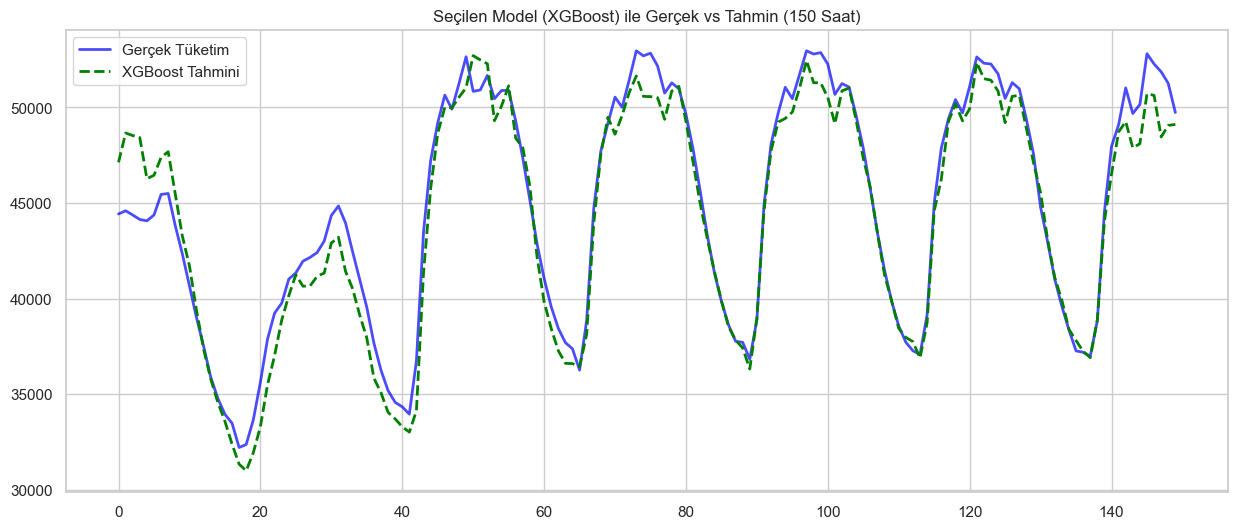

In [8]:
print(f"💾 Seçilen Model Kaydediliyor: {best_model_name}")

# En iyi modeli kaydet
joblib.dump(best_model, 'elektrik_tuketim_modeli.pkl')

# Veri setini de son haliyle kaydet (Veritabanı için)
df.to_csv('ML_Model_Veri.csv', index=False)

print("✅ İşlem Tamamlandı! Dosyalar proje klasörüne oluşturuldu.")

# Son olarak en iyi modelin tahmin grafiğini çizelim
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:150], label='Gerçek Tüketim', color='blue', linewidth=2, alpha=0.7)
plt.plot(y_pred_best[:150], label=f'{best_model_name} Tahmini', color='green', linestyle='--', linewidth=2)
plt.title(f"Seçilen Model ({best_model_name}) ile Gerçek vs Tahmin (150 Saat)")
plt.legend()
plt.show()